<a href="https://colab.research.google.com/github/GauravL98/MAE598_DO/blob/main/mae_598_DO_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [ ]:
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
BOOST_ACCEL = 0.18  # thrust constant
Cd = 0.25 #drag cofficint

density = 0.0179 # density 
A = 10 # crossection area of rocket

Dynamics

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta
        action[2]: Drag 

        state[0] = x
        state[1] = vx
        state[2] = y
        state[3] = vy
        state[4] = theta
        state[5] = Drag in Y 
      
        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... @cc antantantant (Prof Max Yi Ren)

        delta_state_gravity = torch.tensor([0., 0.,0, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Thrust for N initial state
        # N = len(state)
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 1] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])
    
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1)) 

        #for drag
        Vy = torch.matmul(state,torch.tensor([0., 0., 0., 1., 0.]))

        #drag = cd*area*density*0.5*(delta_state**2) 
        drag = -Cd*A*density*0.5*Vy*Vy

        state = state + delta_state  + delta_state_gravity + delta_state_theta - drag 


        # Update state
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0., 0.],
                                 [0., 1., 0., 0., 0.],
                                 [0., 0., 1., FRAME_TIME, 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        

        state = torch.matmul(step_mat, state.T)
        return (state.T)

Controller

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

Simulation

In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[np.random.random(),0.,1.,0.,0.]] 
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

Optimize

In [ ]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        loss_list = np.zeros( epochs)
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            loss_list[epoch]=loss
            
        plt.plot(list(range(epochs)), loss_list)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')

        plt.show()
          
        self.visualize()

        
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        vx = data[:, 1]
        y = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        plt.plot(np.linspace(0., 1.0, num=100),y)
        plt.xlabel('time')
        plt.ylabel('y')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),x)
        plt.xlabel('time')
        plt.ylabel('x')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),vx)
        plt.xlabel('time')
        plt.ylabel('velocity in x direction')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),vy)
        plt.xlabel("time")
        plt.ylabel('velocity in y direction')
        plt.show()
        plt.plot(np.linspace(0., 1.0, num=100),theta)
        plt.xlabel("time")
        plt.ylabel('theta')
        plt.show()

[1] loss: 9.185
[2] loss: 6.463
[3] loss: 5.264
[4] loss: 4.194
[5] loss: 3.042
[6] loss: 1.755
[7] loss: 0.991
[8] loss: 0.517
[9] loss: 0.276
[10] loss: 0.170
[11] loss: 0.109
[12] loss: 0.072
[13] loss: 0.050
[14] loss: 0.034
[15] loss: 0.022
[16] loss: 0.013
[17] loss: 0.009
[18] loss: 0.006
[19] loss: 0.004
[20] loss: 0.003
[21] loss: 0.002
[22] loss: 0.001
[23] loss: 0.001
[24] loss: 0.001
[25] loss: 0.000
[26] loss: 0.000
[27] loss: 0.000
[28] loss: 0.000
[29] loss: 0.000
[30] loss: 0.000


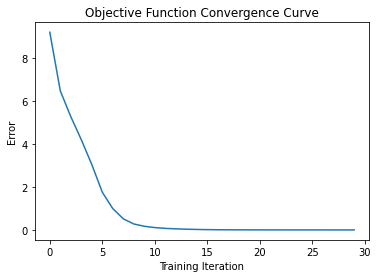

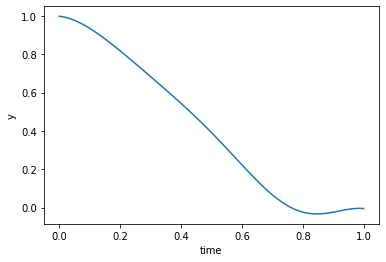

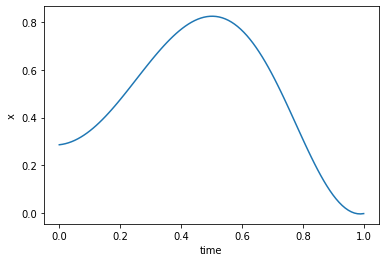

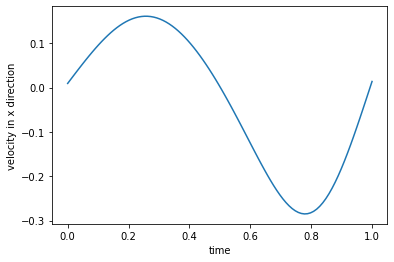

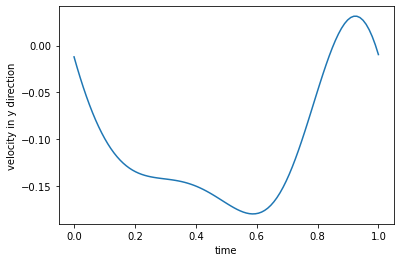

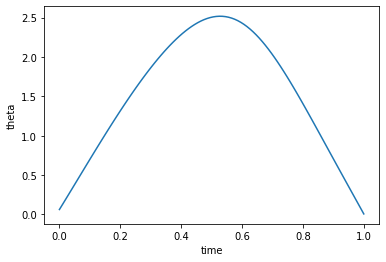

In [ ]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(30)  # training with number of epochs